In [1]:
using ITensors,ITensorMPS
using RandomMeas
using ProgressBars

Precompiling RandomMeas
  ✓ RandomMeas
  1 dependency successfully precompiled in 4 seconds. 255 already precompiled.


In [2]:
N  = 10
χ = 2^(N÷2)
ξ = siteinds("Qubit", N)
ψ = randomMPS(ξ; linkdims=χ);

In [3]:
NAmax = N÷2
nmax = 3
p = zeros(NAmax,nmax-1)
C3 = zeros(NAmax)
r2 = zeros(NAmax)
ITensors.disable_warn_order()
for NA in 1:NAmax
    NAB = 2*NA
    ρT,ξAB = reduce_dm(ψ,1,NAB)
    ρT = flatten(ρT)
    for i in 1:NA
        ρT  = swapind(ρT,ξAB[i],ξAB[i]')
    end
    D, U = eigen(ρT, ξAB, ξAB')
    for k in 1:nmax-1
        for s in 1:dim(D,1)
            p[NA,k] += D[s,s]^(k+1)
        end
    end
    @show NA
    C3[NA] = p[NA,1]^2/p[NA,2]
end

NA = 1
NA = 2
NA = 3
NA = 4
NA = 5


In [4]:
#Perform Randomized measurements
nu=2000
NM=100
data = zeros(Int8,(nu,NM,N))
u = Vector{Vector{ITensor}}()
for r in ProgressBar(1:nu, printing_delay=2)
    push!(u,get_rotations(ξ,1)) #Haar rotations in A
    data[r,:,:] = get_RandomMeas(ψ,u[r],NM)
end

0.0%┣                                        ┫ 0/2.0k [00:03<-1:-34:-25, -3s/it]
0.1%┣                                         ┫ 1/2.0k [00:40<Inf:Inf, InfGs/it]
1.5%┣▋                                            ┫ 29/2.0k [00:42<49:51, 2s/it]
2.9%┣█▎                                           ┫ 59/2.0k [00:45<24:49, 1it/s]
4.3%┣██                                           ┫ 87/2.0k [00:47<17:15, 2it/s]
5.5%┣██▍                                         ┫ 110/2.0k [00:49<14:02, 2it/s]
6.9%┣███                                         ┫ 137/2.0k [00:51<11:33, 3it/s]
8.2%┣███▋                                        ┫ 164/2.0k [00:53<09:53, 3it/s]
9.5%┣████▏                                       ┫ 190/2.0k [00:55<08:44, 3it/s]
10.9%┣████▊                                      ┫ 218/2.0k [00:57<07:46, 4it/s]
12.3%┣█████▎                                     ┫ 246/2.0k [00:59<07:01, 4it/s]
13.7%┣██████                                     ┫ 274/2.0k [01:01<06:25, 4it/s]
15.3%┣██████▋               

In [8]:
C3s = zeros(NAmax)
for NA in ProgressBar(1:NAmax, printing_delay=2)
    NAB = 2*NA
    uAB = [ut[1:NAB] for ut in u]
    ξAB = ξ[1:NAB]
    #@show NA
    ρs = get_batch_shadows(data[:,:,1:NAB],ξAB,uAB,nmax)
    for n in 1:nmax
        for i in 1:NA
             ρs[n] = swapind(ρs[n],ξAB[i],ξAB[i]')
        end
    end
    p = get_moments(ρs, ξAB, nmax)
    #@show p
    C3s[NA] = p[1]^2/p[2]
end

0.0%┣                                                ┫ 0/5 [00:00<00:-1, -0s/it]
60.0%┣████████████████████████████▉                   ┫ 3/5 [00:04<00:04, 2s/it]
80.0%┣██████████████████████████████████████▍         ┫ 4/5 [00:19<00:06, 6s/it]
100.0%┣██████████████████████████████████████████████┫ 5/5 [03:26<00:00, 51s/it]
100.0%┣██████████████████████████████████████████████┫ 5/5 [03:26<00:00, 51s/it]


In [7]:
println(C3s)

[0.8870860463140408, 0.8291201136037603, 1.6339156604398473, 8.17862100203287, -23.519867371466123]


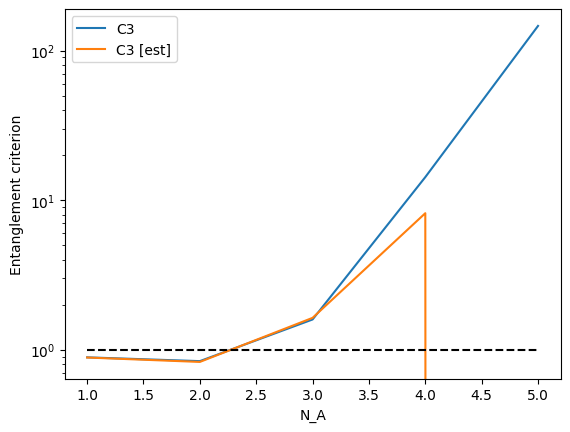

PyObject <matplotlib.legend.Legend object at 0x7f01b68ca7d0>

In [6]:
using PyPlot
PyPlot.plot(1:NAmax,C3,label="C3")
PyPlot.plot(1:NAmax,C3s,label="C3 [est]")
PyPlot.plot(1:NAmax,ones(NAmax),"--k")
xlabel("N_A")
yscale("log")
ylabel("Entanglement criterion")
legend()